In [1]:
IMG_PATH = './Rock-image-patches'
CSV_RGB = './colors_RGB_200.csv'
CSV_LAB = './colors_LAB_200.csv'

MAX_SIZE = (200, 200)
CLUSTERS = 4

#### Imports

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, color
import traceback#, sys, logging
from sklearn.cluster import KMeans

def load_images_from_directory(path, max_size=None):
    x_rgb = []; x_lab = []; y = []; files = [];
    for folder in os.listdir(path):
        if(os.path.isfile(folder)):
            print(os.path.join(path,folder), 'was removed')
            continue
        for file in os.listdir(os.path.join(path,folder)):
            if(not file.lower().endswith(('.png', '.jpg', '.jpeg'))):
                print(os.path.join(path,folder,file), 'was removed')
                continue
            try:
                if max_size == None:
                    # pilmode_doc=https://pillow.readthedocs.io/en/3.0.x/handbook/concepts.html
                    img = io.imread(os.path.join(path,folder,file), pilmode='RGB')
                else:
                    #img = Image.open(os.path.join(path,folder,file)).convert('RGB')
                    #img.thumbnail(max_size, Image.ANTIALIAS)
                    #img = np.array(img)
                    #img = io.imread(os.path.join(path,folder,file), pilmode='RGB')
                    img = cv2.imread(os.path.join(path,folder,file))
                    img = cv2.resize(img, max_size);
                x_rgb.append(img)
                x_lab.append(color.rgb2lab(img)) # illuminant='D65'
                #x_lab.append(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))
            except Exception as e:
                print(f"Error in {path}/{folder}/{file} file\n{e}")
                traceback.print_exc() #print(e, file=sys.stderr) #logging.error(e, exc_info=True)
            y.append(folder)
            files.append(file)
        print(folder, "images were loaded")
    return (x_rgb, x_lab, y, files)

def get_dominant_colors(img):
    reshape = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    cluster = KMeans(n_clusters=CLUSTERS).fit(reshape)
    lb = np.arange(0, len(np.unique(cluster.labels_))+1) # Get the number of different clusters
    (hist, _) = np.histogram(cluster.labels_, bins = lb) # create histogram
    hist = hist.astype("float"); hist /= hist.sum() # normalize
    colors = sorted([(percent, color) for (percent, color) in zip(hist, cluster.cluster_centers_)])
    features = []
    for (percent, color) in colors:
        features.extend(color)
        features.append(percent)
    return features

def get_dominants_plot(features):
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    start = 0
    for i in range(4):
        color_ = np.array(features[i*4:i*4+3])
        percent = features[i*4+3]
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), color_.astype("uint8").tolist(), -1)
        start = end
    return rect

def get_avg_plot(img):
    average = img.mean(axis=0).mean(axis=0)
    avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)
    return avg_patch

### 1. Loading data

In [3]:
import time

start = time.time()
x_rgb, x_lab, y, files = load_images_from_directory(IMG_PATH, MAX_SIZE)
stop = time.time()

print(f"\nData loading time: {stop - start} s")

Granodiorite images were loaded
./Rock-image-patches/.DS_Store was removed
Granite images were loaded
Diorite images were loaded
Monzodiorite images were loaded
Tonalite images were loaded
Gabbro images were loaded

Data loading time: 45.5306441783905 s


In [4]:
import pandas as pd
print('Data visualization')
classes, indices, counts = np.unique(y, return_counts=True, return_index=True)
df = pd.DataFrame({'Classes': classes, 'Counts': counts, 'Start index': indices})
df.sort_values(by=['Start index'], ascending=True, ignore_index='x')

Data visualization


,Classes,Counts,Start index
0,Granodiorite,70,0
1,Granite,70,70
2,Diorite,78,140
3,Monzodiorite,65,218
4,Tonalite,75,283
5,Gabbro,65,358


### 2. Determining the best k number for kmeans

Iterating a range number of clusters for kmeans

In [5]:
print('Image rgb: Gabbro/'+files[415], x_rgb[415].shape)
reshape = x_rgb[415].reshape((x_rgb[415].shape[0] * x_rgb[415].shape[1], x_rgb[415].shape[2]))

#print('Image lab: Gabbro/', files[415], x_lab[415].shape)
#reshape = x_lab[415].reshape((x_lab[415].shape[0] * x_lab[415].shape[1], x_lab[415].shape[2]))

Nclusters = range(2, 20)
score = []; distortions = []
for n in Nclusters:
    k = KMeans(n_clusters=n)
    k.fit(reshape)
    distortions.append(k.inertia_)
    score.append(k.score(reshape))
    print('Kmeans was trained with k =', n)

Image rgb: Gabbro/10715B_P1_Cleaned_02_04.png (200, 200, 3)
Kmeans was trained with k = 2
Kmeans was trained with k = 3
Kmeans was trained with k = 4
Kmeans was trained with k = 5
Kmeans was trained with k = 6
Kmeans was trained with k = 7
Kmeans was trained with k = 8
Kmeans was trained with k = 9
Kmeans was trained with k = 10
Kmeans was trained with k = 11
Kmeans was trained with k = 12
Kmeans was trained with k = 13
Kmeans was trained with k = 14
Kmeans was trained with k = 15
Kmeans was trained with k = 16
Kmeans was trained with k = 17
Kmeans was trained with k = 18
Kmeans was trained with k = 19


Plotting the Elbow curve

In [6]:
# Plot configuration
import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
plt.rc('axes', titlesize=13)
plt.rc('font', size=13)

/Users/sarah/opt/miniconda3/envs/rocks/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


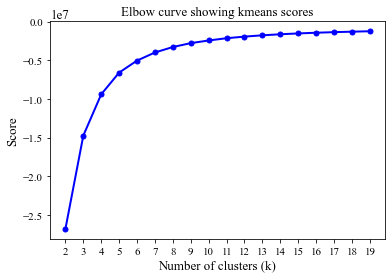

In [7]:
# Plot of Elbow curve with the Kmeans scores
plt.plot(Nclusters, score, 'bo-', linewidth=2,markersize=5)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')
plt.title('Elbow curve showing kmeans scores')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.axes().set_xticks(Nclusters)
#plt.savefig('Elbow curve.png', dpi=300)
plt.show()

/Users/sarah/opt/miniconda3/envs/rocks/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


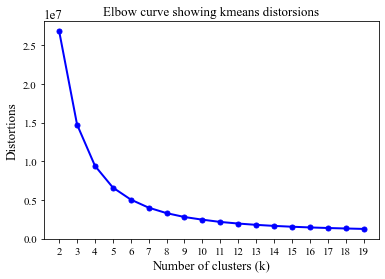

In [8]:
plt.plot(Nclusters, distortions, 'bo-', linewidth=2,markersize=5)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortions')
plt.title('Elbow curve showing kmeans distorsions')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.axes().set_xticks(Nclusters)
#plt.savefig('Elbow curve - distorsions.png', dpi=300)
plt.show()

### 3. Extracting dominant colors from images

In [9]:
extracted_rgb = []
extracted_lab = []

start = time.time()
try:
    i=0
    for rgb in x_rgb:
        features = get_dominant_colors(rgb)
        extracted_rgb.append(features)
        i+=1
except Exception as e:
    print(f"Error in {y[i]}/{files[i]} file, index {i}, rgb shape {x_rgb[i]}\n{e}")
    traceback.print_exc()
stop = time.time()
print(f"\nRGB dominant colors extraction time: {stop - start} s")

start = time.time()
try:
    i=0
    for lab in x_lab:
        features = get_dominant_colors(lab)
        extracted_lab.append(features)
        i+=1
except Exception as e:
    print(f"Error in {y[i]}/{files[i]} file, index {i}, lab shape {x_lab[i]}\n{e}")
    traceback.print_exc()
stop = time.time()
print(f"\nLAB dominant colors extraction time: {stop - start} s")


RGB dominant colors extraction time: 206.01050186157227 s

LAB dominant colors extraction time: 216.85093092918396 s


Plotting dominant colors in sample images

### 4. Add data to CSV

In [10]:
rgb_df = pd.DataFrame(extracted_rgb, files)
rgb_df[16] = y
rgb_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
11830I_P2_01_02.png,91.146654,91.899709,95.701455,0.128325,194.117291,198.722641,201.702155,0.236750,132.788231,135.227866,139.299052,0.279075,163.845317,167.847634,171.808594,0.355850,Granodiorite
12720V_P2.JPG,86.199243,87.587080,88.950781,0.105225,191.135353,195.519616,200.376327,0.224875,131.751443,134.841788,138.228879,0.285150,160.456831,164.659196,169.051452,0.384750,Granodiorite
10715M_P2_01_02.png,61.885181,64.350915,67.644779,0.139750,104.720116,108.974840,112.706513,0.207275,166.056172,170.207254,174.117115,0.303975,136.374499,140.688968,144.911103,0.349000,Granodiorite
12723M_P2_01_02.png,72.077252,71.331961,72.674846,0.158175,124.007253,126.052284,130.293029,0.230350,192.624768,196.752142,199.985160,0.283025,160.041527,163.445596,167.606218,0.328450,Granodiorite
11830I_P2_01_01.png,93.111528,100.464514,103.554825,0.133825,133.693202,138.925123,142.433892,0.252375,196.631524,198.461936,201.002585,0.262650,166.878915,170.132448,173.204957,0.351150,Granodiorite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12717C_P2_01_03.png,175.115480,177.792819,179.430370,0.159800,80.481194,82.832510,87.537562,0.246725,143.310641,146.006496,148.310550,0.274275,112.693396,114.662814,117.989780,0.319200,Gabbro
12717B_P2_03_01.png,174.932013,186.658024,190.183953,0.122925,147.224670,154.384220,157.467488,0.257750,103.029083,107.165415,110.284978,0.286250,124.518954,129.683099,132.878783,0.333075,Gabbro
12717B_P2_01_04.png,168.476651,173.791734,176.566291,0.093000,140.363424,144.699628,147.666135,0.235275,98.574804,102.012429,105.983735,0.325850,118.272931,122.128515,125.658113,0.345875,Gabbro
10719CC_P2.jpg,179.523480,184.039875,186.148789,0.151875,143.183634,147.120994,148.772528,0.256475,73.191874,78.019142,80.173544,0.277225,107.231435,111.524581,113.224128,0.314425,Gabbro


In [11]:
lab_df = pd.DataFrame(extracted_lab, files)
lab_df[-1] = y
lab_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,-1
11830I_P2_01_02.png,38.280482,0.820646,-2.290804,0.118375,79.442609,-1.104434,-1.981014,0.254500,55.501919,0.059052,-2.478294,0.267550,67.933753,-0.597192,-2.530081,0.359575,Granodiorite
12720V_P2.JPG,36.335461,-0.125809,-0.937273,0.097825,78.315572,-0.623724,-2.907428,0.242225,55.348765,-0.372943,-2.140021,0.268775,66.785338,-0.615636,-2.765028,0.391175,Granodiorite
10715M_P2_01_02.png,25.917947,-0.052033,-2.328551,0.123200,43.752661,-0.750194,-2.625291,0.184675,68.881471,-0.750495,-2.490155,0.336050,57.046790,-0.684879,-2.777347,0.356075,Granodiorite
12723M_P2_01_02.png,29.915507,0.747345,-0.644449,0.152625,52.254458,0.256847,-2.538865,0.227600,79.002953,-0.869440,-2.065535,0.293425,66.661952,-0.359162,-2.564519,0.326350,Granodiorite
11830I_P2_01_01.png,41.279193,-2.012781,-2.705846,0.122250,56.574847,-1.186368,-2.579405,0.241375,79.585952,-0.204296,-1.436400,0.281900,68.781938,-0.544802,-1.992616,0.354475,Granodiorite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12717C_P2_01_03.png,71.476200,-0.722836,-1.106424,0.184875,34.447481,0.302476,-3.211572,0.222900,59.223967,-0.442395,-1.548969,0.279175,47.171339,0.028690,-2.109919,0.313050,Gabbro
12717B_P2_03_01.png,74.610865,-3.429082,-3.124550,0.129325,62.845342,-1.956301,-2.433998,0.265125,44.845291,-0.759880,-2.313951,0.274725,53.573951,-1.169913,-2.354858,0.330825,Gabbro
12717B_P2_01_04.png,69.950427,-1.416865,-1.984481,0.106025,59.127113,-0.991413,-2.095343,0.242575,42.803347,-0.355461,-2.743960,0.309825,50.617820,-0.676171,-2.417985,0.341575,Gabbro
10719CC_P2.jpg,73.790322,-1.230853,-1.552446,0.167050,32.326629,-1.337949,-1.965050,0.258900,59.627526,-1.098975,-1.330447,0.266100,45.803563,-1.225701,-1.501618,0.307950,Gabbro


In [12]:
rgb_df.to_csv(CSV_RGB, header=None)
lab_df.to_csv(CSV_LAB, header=None)